In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load the data and perform EDA (if needed)
data = pd.read_csv('final_dataframe.csv')
data

,Unnamed: 0,participant,trial,onset_ms,difficulty,correctResponse,participantResponse,RT,errorLR,isComission,isOmission,time_ms,ECG,filtered_ecg,normalized_ecg,RR_intervals,Heart_Rate,HRV,RMSSD,SDNN
0,1,1,3,11342,0,0,0,0.395806,0,NaN,0.0,11342,-172.5,-15.836893,-0.058880,2.798,21.443888,7.828,7.828,2.515000
1,2,1,11,21968,0,1,1,0.687468,0,NaN,0.0,21968,154.0,-48.734000,-0.183536,10.626,5.646527,-2.750,2.750,4.320176
2,3,1,15,27046,0,2,1,0.534686,0,NaN,0.0,27046,179.5,-91.812792,-0.346774,5.078,11.815675,3.946,3.946,3.784834
3,4,1,16,28242,1,0,0,0.638847,0,NaN,0.0,28242,163.5,-103.752097,-0.445721,1.196,50.167224,-2.336,2.336,3.992489
4,5,1,17,29852,1,0,0,0.798577,0,NaN,0.0,29852,207.0,-103.752097,-0.392016,1.610,37.267081,5.426,5.426,3.874637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3979,3980,9,492,712734,1,0,0,0.541629,0,NaN,0.0,712734,-290.0,101.858347,0.387101,4.040,14.851485,446.740,446.740,990.523787
3980,3981,9,494,715244,1,0,0,0.458256,0,NaN,0.0,715244,-36.0,25.407515,0.097407,2.510,23.904382,-444.098,444.098,990.424418
3981,3982,9,496,717886,1,1,1,0.506915,0,NaN,0.0,717886,51.0,-15.012882,-0.055757,2.642,22.710068,445.196,445.196,990.325192
3982,3983,9,497,718984,0,0,0,0.374999,0,NaN,0.0,718984,-18.5,-15.012882,-0.096331,1.098,54.644809,-441.588,441.588,990.225622


In [3]:
# Define independent variables (HRV features) and dependent variable (Response Time or Difficulty)
features_hrv = ['RMSSD', 'SDNN', 'HRV']  
target_hrv = 'participantResponse' 

In [4]:
# Prepare feature matrix X and target vector y
X_hrv = data[features_hrv]
y_hrv = data[target_hrv]

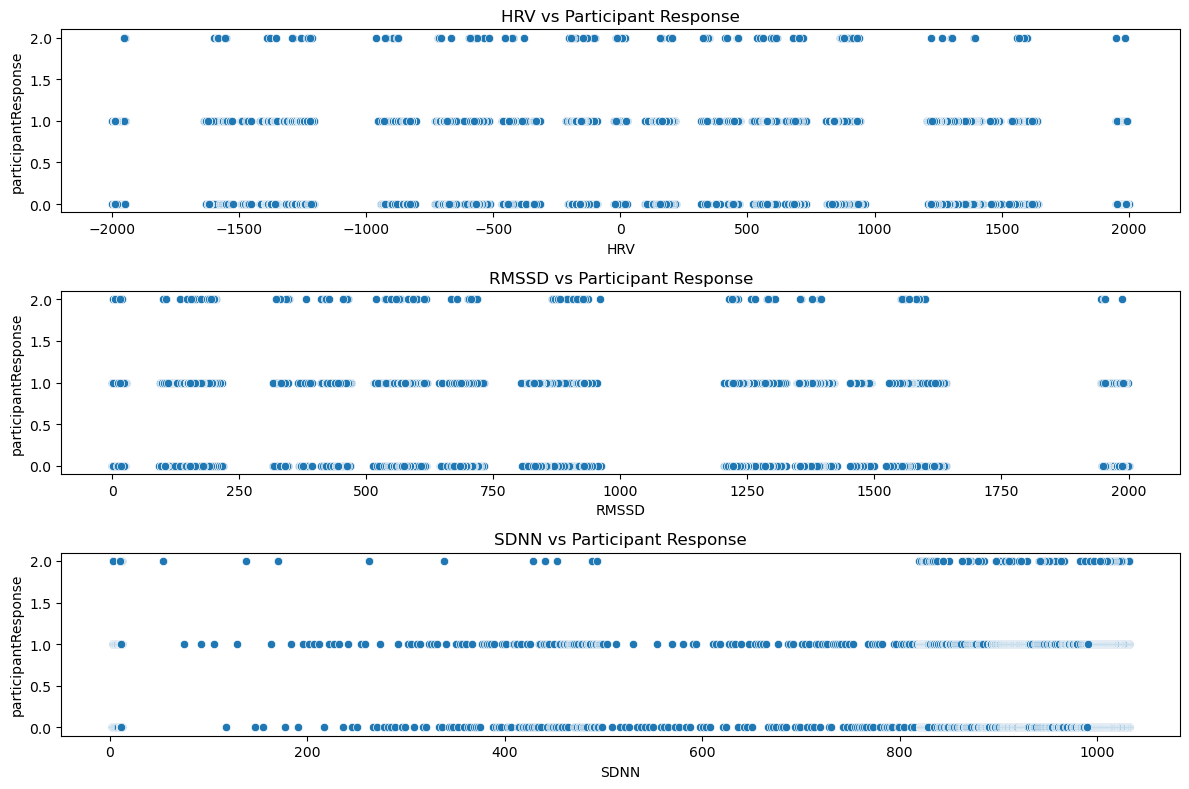

In [5]:
# Visualize relationships between HRV features and Participant Response
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
sns.scatterplot(x='HRV', y='participantResponse', data=data)
plt.title('HRV vs Participant Response')
plt.subplot(3, 1, 2)
sns.scatterplot(x='RMSSD', y='participantResponse', data=data)
plt.title('RMSSD vs Participant Response')
plt.subplot(3, 1, 3)
sns.scatterplot(x='SDNN', y='participantResponse', data=data)
plt.title('SDNN vs Participant Response')
plt.tight_layout()
plt.show()


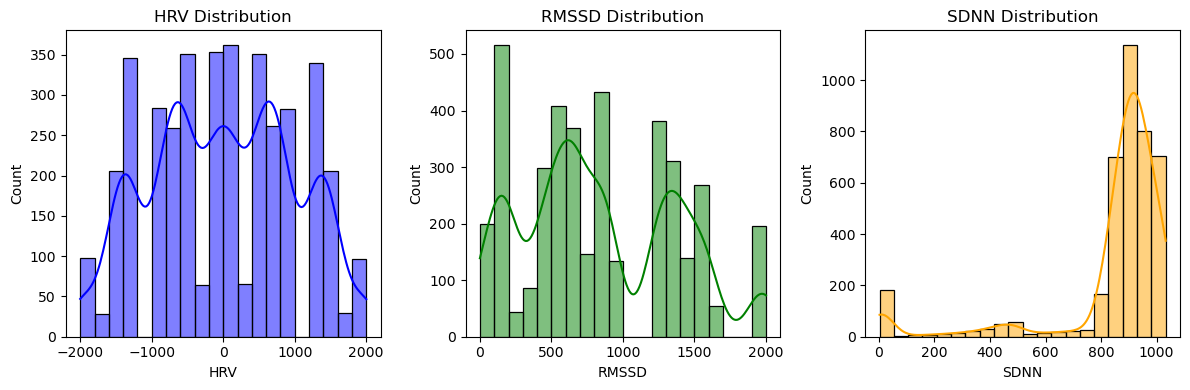

In [6]:
# Histograms of HRV features
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(data['HRV'], bins=20, color='blue', kde=True)
plt.title('HRV Distribution')
plt.subplot(1, 3, 2)
sns.histplot(data['RMSSD'], bins=20, color='green', kde=True)
plt.title('RMSSD Distribution')
plt.subplot(1, 3, 3)
sns.histplot(data['SDNN'], bins=20, color='orange', kde=True)
plt.title('SDNN Distribution')
plt.tight_layout()
plt.show()

In [7]:
# Split data into training and testing sets
X_train_hrv, X_test_hrv, y_train_hrv, y_test_hrv = train_test_split(X_hrv, y_hrv, test_size=0.2, random_state=42)

In [8]:
# Feature scaling - normalization
scaler_hrv = StandardScaler()
X_train_scaled_hrv = scaler_hrv.fit_transform(X_train_hrv)
X_test_scaled_hrv = scaler_hrv.transform(X_test_hrv)

In [9]:
# Hyperparameter tuning for Random Forest Regressor
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [10]:
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train_scaled_hrv, y_train_hrv)
best_rf_model = grid_search_rf.best_estimator_

In [11]:
# Train a Random Forest Regressor for HRV prediction
rf_regressor_hrv = RandomForestRegressor(random_state=42)
rf_regressor_hrv.fit(X_train_scaled_hrv, y_train_hrv)
rf_predictions_hrv = rf_regressor_hrv.predict(X_test_scaled_hrv)
rf_mse_hrv = mean_squared_error(y_test_hrv, rf_predictions_hrv)
print("Random Forest HRV Model MSE:", rf_mse_hrv)

Random Forest HRV Model MSE: 0.37310752823086574


In [12]:
# Train a Gradient Boosting Regressor for HRV prediction
gb_regressor_hrv = GradientBoostingRegressor(random_state=42)
gb_regressor_hrv.fit(X_train_scaled_hrv, y_train_hrv)
gb_predictions_hrv = gb_regressor_hrv.predict(X_test_scaled_hrv)
gb_mse_hrv = mean_squared_error(y_test_hrv, gb_predictions_hrv)
print("Gradient Boosting HRV Model MSE:", gb_mse_hrv)

Gradient Boosting HRV Model MSE: 0.32315811419662416


In [18]:
# Initialize a list to store the cross-validation MSE scores
cv_scores_nn = []

In [21]:
# Create KFold cross-validation object
n_splits = 5
kf = KFold(n_splits=n_splits)

In [22]:
# Train the Neural Network model using cross-validation
for train_idx, val_idx in kf.split(X_train_scaled_hrv):
    X_train_cv, X_val_cv = X_train_scaled_hrv[train_idx], X_train_scaled_hrv[val_idx]
    y_train_cv, y_val_cv = y_train_hrv.iloc[train_idx], y_train_hrv.iloc[val_idx]
    
    # Create and compile the Neural Network model
    nn_model_hrv = Sequential()
    nn_model_hrv.add(Dense(64, activation='relu', input_shape=(X_train_scaled_hrv.shape[1],)))
    nn_model_hrv.add(Dropout(0.5))
    nn_model_hrv.add(Dense(32, activation='relu'))
    nn_model_hrv.add(Dropout(0.5))
    nn_model_hrv.add(Dense(1))
    nn_model_hrv.compile(optimizer='adam', loss='mean_squared_error')
    
    # Early stopping callback for NN
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    
    # Train the Neural Network model
    history_nn_hrv = nn_model_hrv.fit(X_train_cv, y_train_cv, epochs=100, batch_size=64,
                                      validation_data=(X_val_cv, y_val_cv),
                                      callbacks=[early_stopping])
    
    # Evaluate the Neural Network model on the validation set
    val_loss_nn_hrv = nn_model_hrv.evaluate(X_val_cv, y_val_cv)
    cv_scores_nn.append(val_loss_nn_hrv)

Epoch 1/100
40/40 [==============================] - 1s 8ms/step - loss: 0.5211 - val_loss: 0.3457
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 0.4174 - val_loss: 0.3544
Epoch 3/100
40/40 [==============================] - 0s 4ms/step - loss: 0.4010 - val_loss: 0.3522
Epoch 4/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3785 - val_loss: 0.3451
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3654 - val_loss: 0.3448
Epoch 6/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3539 - val_loss: 0.3410
Epoch 7/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3564 - val_loss: 0.3432
Epoch 8/100
40/40 [==============================] - 0s 9ms/step - loss: 0.3418 - val_loss: 0.3399
Epoch 9/100
40/40 [==============================] - 0s 5ms/step - loss: 0.3343 - val_loss: 0.3330
Epoch 10/100
40/40 [==============================] - 0s 5ms/step - loss: 0.3381 - val_loss: 0.3356
Epoch 11/

40/40 [==============================] - 0s 5ms/step - loss: 0.3152 - val_loss: 0.3201
Epoch 37/100
40/40 [==============================] - 0s 3ms/step - loss: 0.3141 - val_loss: 0.3200
Epoch 38/100
40/40 [==============================] - 0s 7ms/step - loss: 0.3124 - val_loss: 0.3199
Epoch 39/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3137 - val_loss: 0.3202
Epoch 40/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3135 - val_loss: 0.3198
Epoch 41/100
40/40 [==============================] - 0s 7ms/step - loss: 0.3125 - val_loss: 0.3196
Epoch 42/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3127 - val_loss: 0.3196
Epoch 43/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3132 - val_loss: 0.3194
Epoch 44/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3114 - val_loss: 0.3193
Epoch 45/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3130 - val_loss: 0.3193
Epoch 46/100


40/40 [==============================] - 0s 6ms/step - loss: 0.3157 - val_loss: 0.3115
Epoch 51/100
40/40 [==============================] - 0s 6ms/step - loss: 0.3164 - val_loss: 0.3119
Epoch 52/100
40/40 [==============================] - 0s 5ms/step - loss: 0.3149 - val_loss: 0.3128
Epoch 53/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3151 - val_loss: 0.3112
Epoch 54/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3151 - val_loss: 0.3114
Epoch 55/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3146 - val_loss: 0.3113
Epoch 56/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3147 - val_loss: 0.3115
Epoch 57/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3154 - val_loss: 0.3118
Epoch 58/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3157 - val_loss: 0.3113
Epoch 59/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3138 - val_loss: 0.3106
Epoch 60/100


20/20 [==============================] - 0s 2ms/step - loss: 0.3061
Epoch 1/100
40/40 [==============================] - 1s 8ms/step - loss: 0.4857 - val_loss: 0.3401
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 0.4064 - val_loss: 0.3491
Epoch 3/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3815 - val_loss: 0.3412
Epoch 4/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3605 - val_loss: 0.3436
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3593 - val_loss: 0.3358
Epoch 6/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3536 - val_loss: 0.3369
Epoch 7/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3415 - val_loss: 0.3317
Epoch 8/100
40/40 [==============================] - 0s 3ms/step - loss: 0.3377 - val_loss: 0.3294
Epoch 9/100
40/40 [==============================] - 0s 3ms/step - loss: 0.3442 - val_loss: 0.3341
Epoch 10/100
40/40 [=====================

In [23]:
# Calculate the mean of the cross-validation MSE scores
cv_mean_nn = np.mean(cv_scores_nn)
print("Cross-Validation Mean MSE for Neural Network:", cv_mean_nn)

Cross-Validation Mean MSE for Neural Network: 0.31414188742637633


In [30]:
print("Cross-Validation MSE Scores:")
print("Random Forest:", -cv_scores_rf.mean())
print("Gradient Boosting:", -cv_scores_gb.mean())
print("Neural Network:", -cv_mean_nn.mean())

Cross-Validation MSE Scores:
Random Forest: 0.3202117323676897
Gradient Boosting: 0.32220094231929347
Neural Network: -0.31414188742637633


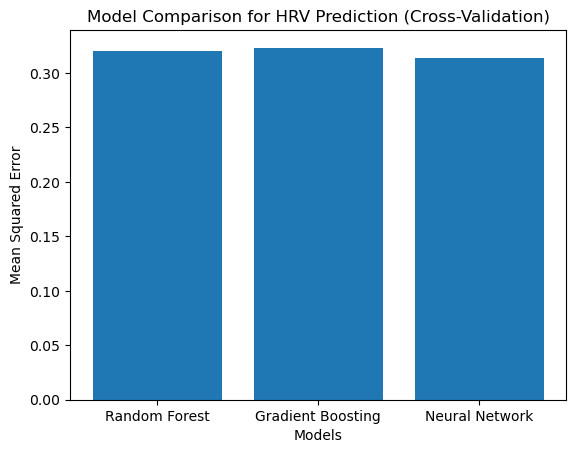

In [26]:
# Visualize the comparison of model MSEs
models = ['Random Forest', 'Gradient Boosting', 'Neural Network']
mse_scores = [-grid_search_rf.best_score_, gb_mse_hrv, cv_mean_nn]
plt.bar(models, mse_scores)
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.title('Model Comparison for HRV Prediction (Cross-Validation)')
plt.show()

25/25 [==============================] - 0s 1ms/step


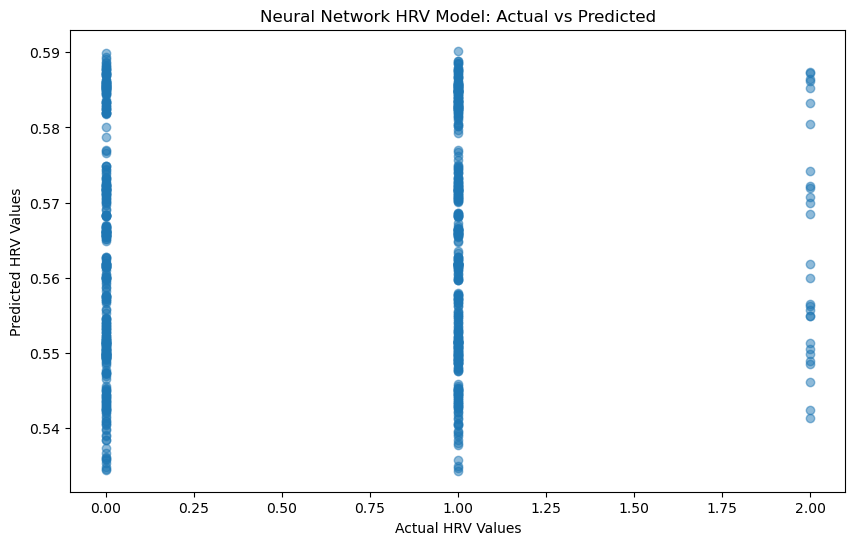

In [27]:
# Visualize Actual vs Predicted results for Neural Network
plt.figure(figsize=(10, 6))
plt.scatter(y_test_hrv, nn_model_hrv.predict(X_test_scaled_hrv), alpha=0.5)
plt.xlabel('Actual HRV Values')
plt.ylabel('Predicted HRV Values')
plt.title('Neural Network HRV Model: Actual vs Predicted')
plt.show()

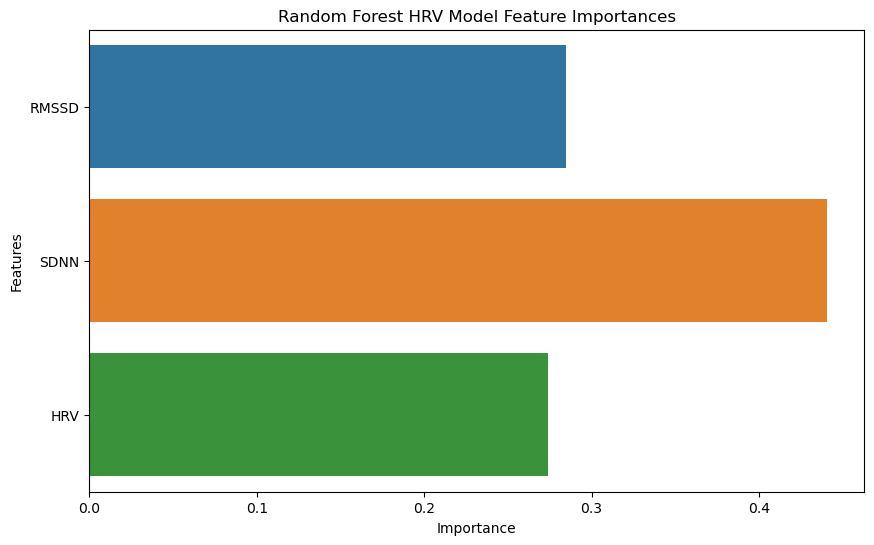

In [28]:
# Visualize Feature Importances for Random Forest
plt.figure(figsize=(10, 6))
feature_importances_hrv = rf_regressor_hrv.feature_importances_
sns.barplot(x=feature_importances_hrv, y=features_hrv)
plt.title('Random Forest HRV Model Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()